# Train YOLO Model on RealWaste Dataset

In [ ]:
import os
import shutil
import random
from pathlib import Path
from ultralytics import YOLO

dataset_path = Path('datasets/RealWaste')
processed_path = Path('datasets/processed')
train_path = processed_path / 'train'
val_path = processed_path / 'val'

if processed_path.exists():
    shutil.rmtree(processed_path)

train_path.mkdir(parents=True, exist_ok=True)
val_path.mkdir(parents=True, exist_ok=True)

classes = [d.name for d in dataset_path.iterdir() if d.is_dir()]
print(f"Found classes: {classes}")

# Split ratio
split_ratio = 0.8

for class_name in classes:
    class_dir = dataset_path / class_name
    images = list(class_dir.glob('*.jpg'))
    random.shuffle(images)
    
    split_idx = int(len(images) * split_ratio)
    train_images = images[:split_idx]
    val_images = images[split_idx:]
    
    # Create class directories in train and val
    (train_path / class_name).mkdir(exist_ok=True)
    (val_path / class_name).mkdir(exist_ok=True)
    
    for img in train_images:
        shutil.copy(img, train_path / class_name / img.name)
        
    for img in val_images:
        shutil.copy(img, val_path / class_name / img.name)
        
    print(f"Processed {class_name}: {len(train_images)} train, {len(val_images)} val")


Found classes: ['Food Organics', 'Glass', 'Vegetation', 'Paper', 'Plastic', 'Textile Trash', 'Metal', 'Miscellaneous Trash', 'Cardboard']
Processed Food Organics: 328 train, 83 val
Processed Glass: 336 train, 84 val
Processed Vegetation: 348 train, 88 val
Processed Paper: 400 train, 100 val
Processed Plastic: 736 train, 185 val
Processed Textile Trash: 254 train, 64 val
Processed Metal: 632 train, 158 val
Processed Miscellaneous Trash: 396 train, 99 val
Processed Cardboard: 368 train, 93 val


In [ ]:
model = YOLO('yolov8n-cls.pt')  # load a pretrained model (recommended for training)

results = model.train(data=str(processed_path.absolute()), epochs=2, imgsz=224)


Ultralytics 8.3.233 🚀 Python-3.14.0 torch-2.9.1+cu128 CPU (Intel Core Ultra 7 258V)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/user/projects/ai-plastic-spotter/datasets/processed, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=2, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, pe

Top prediction: Plastic (0.492)
  Plastic: 0.492
  Paper: 0.197
  Cardboard: 0.113
  Miscellaneous Trash: 0.108
  Food Organics: 0.022


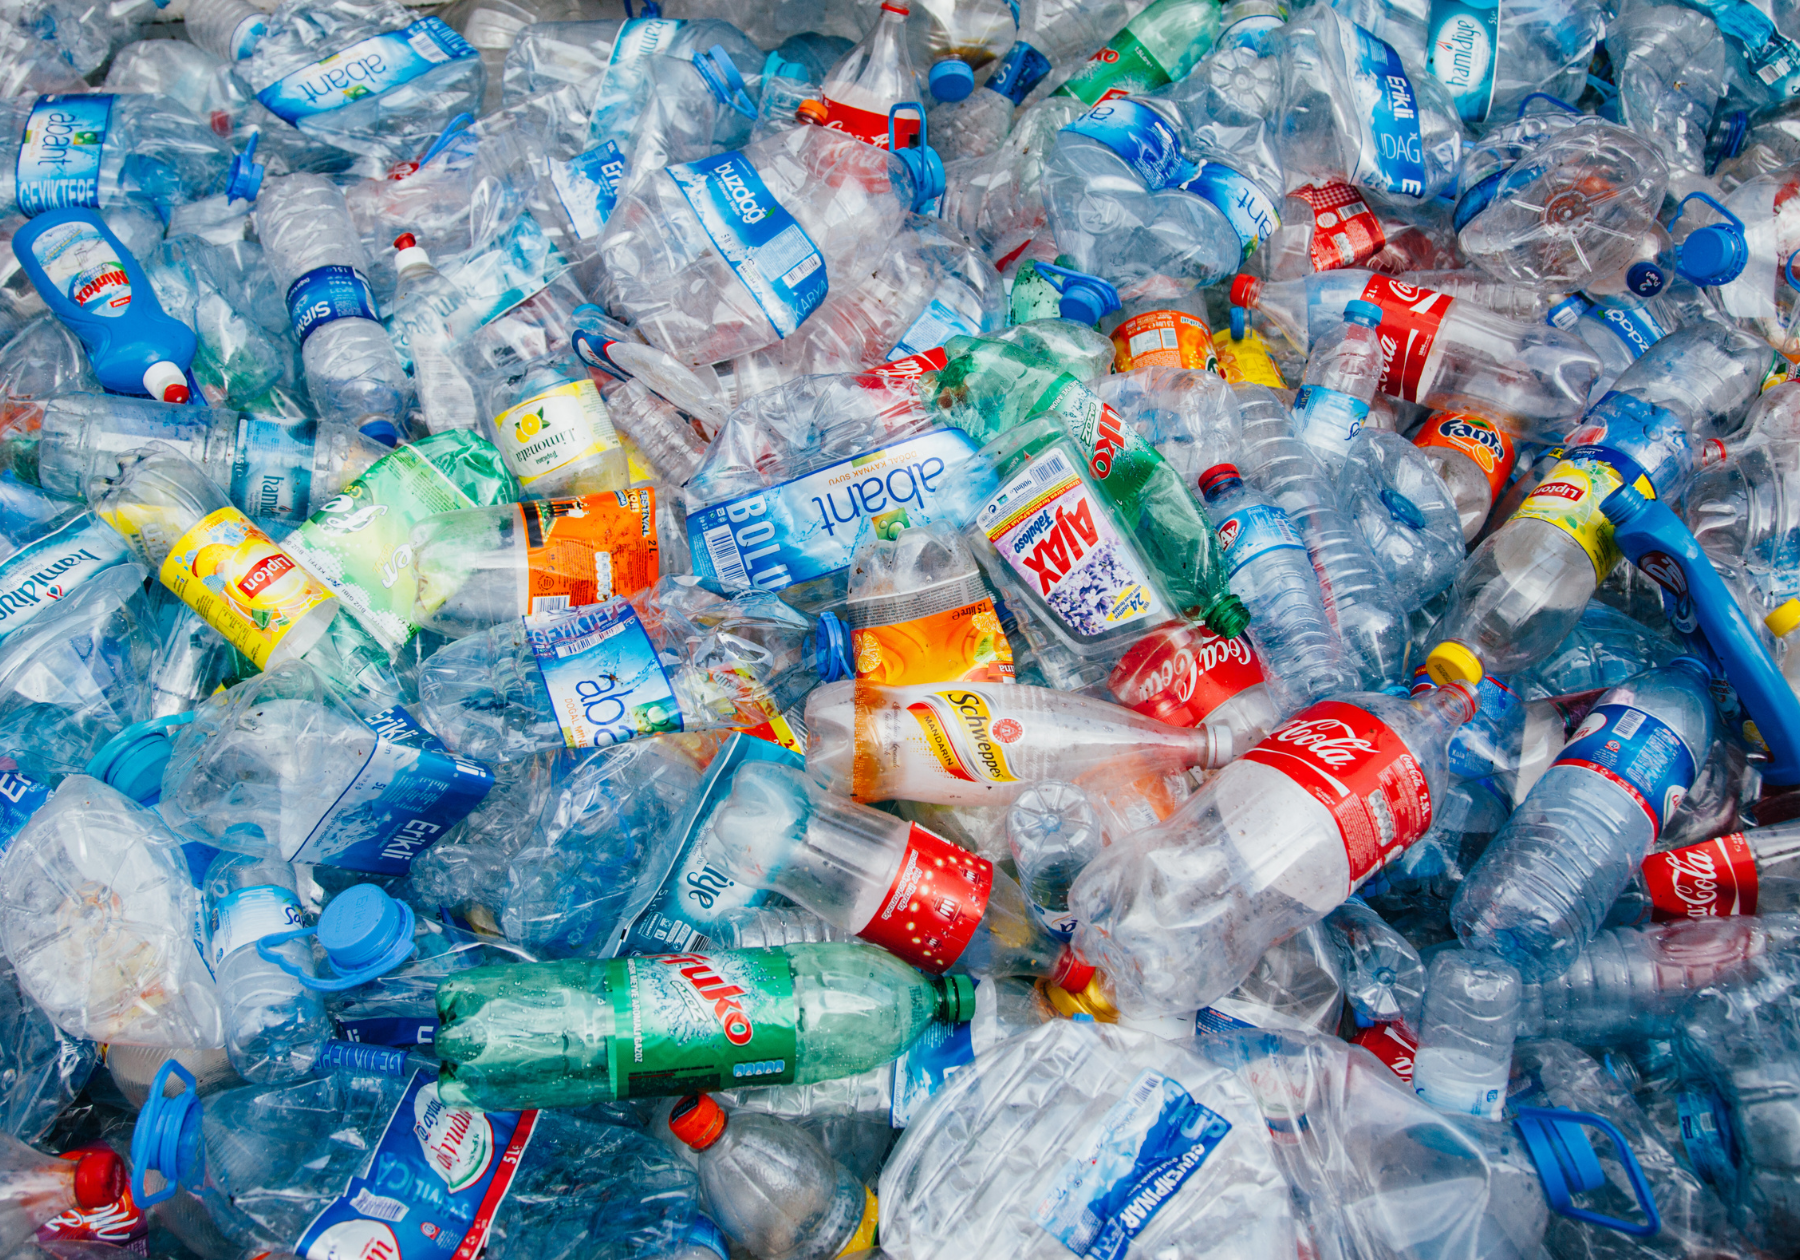

In [ ]:
best_weights = Path('runs/classify/train3/weights/best.pt')
if not best_weights.exists():
    raise FileNotFoundError(f"{best_weights} not found; rerun training or adjust the path.")

test_image = Path('plastic-bottle-waste.png')
if not test_image.exists():
    raise FileNotFoundError(f"{test_image} not found; place the sample image alongside the notebook.")

infer_model = YOLO(str(best_weights))
results = infer_model.predict(source=str(test_image), imgsz=640, conf=0.3, verbose=False)
result = results[0]

if hasattr(result, 'probs') and result.probs is not None:
    probs = result.probs
    top_idx = int(probs.top1)
    top_label = result.names[top_idx]
    print(f"Top prediction: {top_label} ({float(probs.top1conf):.3f})")
    # Print the top few confidences exposed by the Probs helper
    for idx, conf in zip(probs.top5, probs.top5conf):
        label = result.names[idx]
        print(f"  {label}: {float(conf):.3f}")
else:
    print('Unexpected output format; check that the model is a classification checkpoint.')

# Display the test image that was classified
from PIL import Image
from IPython.display import display
display(Image.open(test_image))